# Self-Avoiding Random Walks (SAW)

## Simple-Minded Algorithm

A self-avoiding random walk (SAW) is a random walk on a lattice that is not allowed to revisit a site it has already visited (i.e., it cannot intersect with iself). We focus here on square lattices, although it should be noted that the fundamental results are independent on the particular lattice structure chosen (but this is a subtle point). We will particularly look at the way the mean squared end-to-end distance (aka mean-squared displacement or square radius of gyration in the language of polymer physics) behaves as we change the length of the walk. We will find that for the SAW this depends on dimensionality of the space, quite differently from what we are used to for a simple random walk: recall that there, the typical "diffusive scaling" $\langle r^2\rangle\sim N$ holds for an $N$-step random walk irrespective of the spatial dimension. The expectation that random walks evolve as fractals without an inherent scale suggests the ansatz $\langle r^2\rangle\sim N^{2\nu}$ for the SAW, where $\nu$ is an exponent to determine and $\nu=1/2$ would indicate the ordinary-random-walk behavior. It is interesting to test for the exponent in 2D, 3D, 4D (and perhaps 5D) numerically.

This python3/jupyter notebook allows to play around with simple simulations of the self-avoiding randomw walk (SAW). It has mostly been tested in 2D, although at least parts of the code should be more general for d-dimensional cubic lattices.
(The notebook is part of the lecture course on stochastic processes @ HHU Düsseldorf, summer term 2020.)

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
import itertools
%matplotlib notebook
import ipywidgets as widgets

In [2]:
# helper to generate a list of unit vectors pointing to the nearest neighbors of the d-dimensional lattice
def squareGrid (d):
    return (np.array(list(map(lambda e:(e,-e),np.identity (d,dtype="int")))).reshape(2*d,d))

Generating SAW on the computer is actually harder than one might first think. The reason is that building these walks step by step (by adding a new segment to either end in every step) tends to get stuck as the ends of the random walk eventually "self-trap" in lattice sites where all neighbors are already occupied by previous steps of the walk. We can quickly demonstrate this, by using a very simple algorithm:
The following command generates a self-avoiding walk in $d$ dimensions with at most $n$ steps. At every step, we first try all possible lattice directions and check whether adding them would be allowed. Then we choose at random one out of the allowed continuations. The procedure terminates either with a SAW of the desired length or with one that is shorter and self-trapped at one end. (One could then try adding segments to the other end still, but this does not solve the fundamental issue behind this procedure.)

In [3]:
def simpleSAW (n,d):
    pts = [np.zeros(d,dtype="int")] # start at origin
    moves = squareGrid (d)
    i = 0
    while i < n:
        possible_moves = []
        for m in moves:
            tp = pts[-1]+m # test point and see whether it is allowed
            allowed = True
            for p in pts:
                if np.array_equal(p,tp):
                    allowed = False
            if allowed:
                possible_moves.append(m)
        if len(possible_moves)>0: # if we still have possibilities
            pts.append (pts[-1] + possible_moves[np.random.choice(len(possible_moves))])
            i += 1
        else:
            break
    return (np.array(pts))

Try evaluating the following cell several times (to seed the random-number generator differently). The initial and end points of the generated SAW are shown in green and red, respectively. Use the slider to unfold the sequence of steps.

<IPython.core.display.Javascript object>


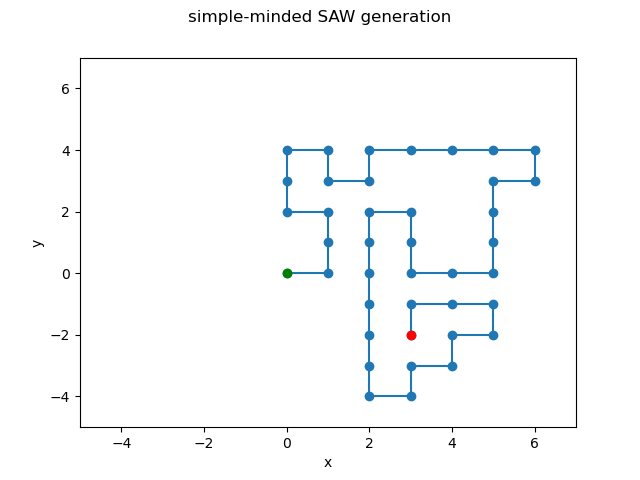

Widget Javascript not detected.  It may not be installed or enabled properly.


generated SAW with 39 steps (tried 100)


In [4]:
N1 = 100
saw1 = simpleSAW(N1,2)
fig1,ax1 = plt.subplots()
fig1.suptitle('simple-minded SAW generation')
x1,y1 = saw1.T
line1, = ax1.plot(x1[0],y1[0],'-o')
ax1.plot (x1[0],y1[0],'o',color='green')
ax1.plot (x1[-1],y1[-1],'o',color='red')
ax1.set_xlim(np.min(saw1)-1,np.max(saw1)+1)
ax1.set_ylim(np.min(saw1)-1,np.max(saw1)+1)
ax1.set_xlabel('x')
ax1.set_ylabel('y')
def update_fig1 (l):
    if l>=0 and l<len(saw1): le=l
    else: le=len(saw1)
    line1.set_xdata(x1[:le])
    line1.set_ydata(y1[:le])
    fig1.canvas.draw_idle()
widgets.interact(update_fig1,l=widgets.IntSlider(value=N1+1,min=1,max=N1+1))
print ("generated SAW with {} steps (tried {})".format(len(saw1)-1,N1))

(A reminder about "random numbers": computers do not normally generate true random numbers, instead they use pseudo-random number generators. These are typically iterative schemes that produce a sequence of numbers with a very long repeat pattern, so that, given a certain state of the generator, the next number appears unpredictable. In fact, of course, the sequences are fully deterministic. The generator yields a unique sequence, given some initial "seed". Repeating everything with the same seed will return exactly the same "random-looking" sequence and guarantee reproducible results. So in principle, it would be wise to add code to fix the seed of the random-number generator explicitly.)

The following histogram demonstrates the problem of the simple-minded algorithm: it makes a certain number of trials $M$ and plots a histogram of the resulting lengths that could be achieved, aiming for length $N=100$. There is a fat tail of shorter lengths. Interestingly, the problem does not go away in higher dimensions, it just appears later.

In [5]:
M1 = 500
N1 = 100
walklengths1 = list(map(lambda w:len(w),map(lambda i:simpleSAW(N1,2),range(M1))))

<IPython.core.display.Javascript object>


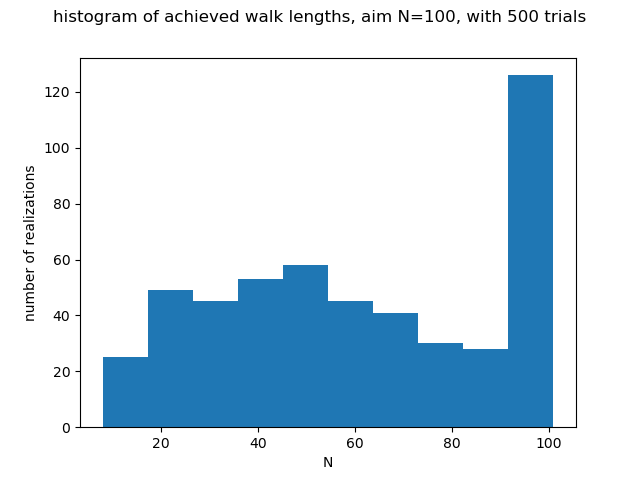

In [6]:
plt.figure ()
plt.hist (walklengths1)
plt.suptitle('histogram of achieved walk lengths, aim N={}, with {} trials'.format(N1,M1))
plt.xlabel('N')
plt.ylabel('number of realizations')
plt.show ()

## The "slithering snake" algorithm

There are two commonly quoted algorithms that are used to generate long self-avoiding walks: the "slithering snake" and the "pivot rotation" algorithm. Both algorithms define transformation rules for self-avoiding walks: they take one such walk and propose another one of equal length. Note that the newly proposed walk may or may not be actually different from the original one; nevertheless it counts as a new trial always. (This is the essence of many Monte Carlo computer simulation algorithms: they try to generate a new configuration from some old one, and if they fail to do so due to some constraint, it is important to count the old configuration again when calculating statistical averages.)

The slithering snake algorithm takes a given SAW and tries to add one new segment to one end. If that succeeds, the first step of the given SAW is removed so that another SAW of the same length is generated. If you imagine what happens graphically, it becomes obvious why this is called the "slithering snake" algorithm, sometimes also called a "reptation" algorithm. If the addition of a new segment is not successful (because by chance the attempt of adding a new step would cause a self-intersection), the algorithm returns the original walk in reverse order, so that calling it again results in trying to add a step to the other end.

Applications of this algorithm typically start with a very simple SAW and iterate the slithering-snake steps for some number of steps $M$. In particular, we start with an extended line of $N$ steps, which is a valid but very atypical SAW. Thus it takes a number of iterations to achieve states that look like they are "more typical", in the sense that the MSD calculated from them is closer to the ensemble average. The number of steps needed to iterate away from the atypical initial configuration of course increases with increasing $N$.

In [7]:
def straightLine (d,n):
    directions = squareGrid(d)
    return (np.append([np.zeros(d,dtype="int")],np.add.accumulate(list(map(lambda d:directions[0],range(n)))),axis=0))

In [8]:
def slitheringSnakeStep (saw, directions):
    m = directions[np.random.choice(len(directions))]
    tp = saw[-1]+m # try to add a new point with random direction
    allowed = True
    for p in saw[:-1]:
        if np.array_equal(p,tp):
            allowed = False
    if allowed:
        return (np.append(saw[1:],[tp],axis=0))
    else:
        return (np.flipud(saw)) # flipped copy
def slitheringSnakeSAW (n,d,m):
    directions = squareGrid(d)
    # we start here with an extended line that surely is a valid (if very atypical) SAW
    saw = straightLine(d,n)
    sawlist = [saw]
    i = 0
    while i < m:
        sawlist = np.append(sawlist,[slitheringSnakeStep(sawlist[-1],directions)],axis=0)
        i += 1
    return (sawlist)
# a bit ugly to repeat code, but here is a variant that calculates the MSD after dropping a given number of
# initial steps, and for memory reasons this code variant does not store all generated walks
def slitheringSnakeMSD (n,d,m,minit):
    directions = squareGrid(d)
    saw = straightLine(d,n)
    msd = 0
    msdcnt = 0
    i = 0
    while i < m:
        saw = slitheringSnakeStep(saw,directions)
        if i >= minit:
            dr = saw[-1] - saw[0]
            msd += dr.dot(dr)
            msdcnt += 1
        i += 1
    return (msd/msdcnt)

In [9]:
N2 = 40
M2 = 1000
sawlist2 = slitheringSnakeSAW (N2,2,M2)

<IPython.core.display.Javascript object>


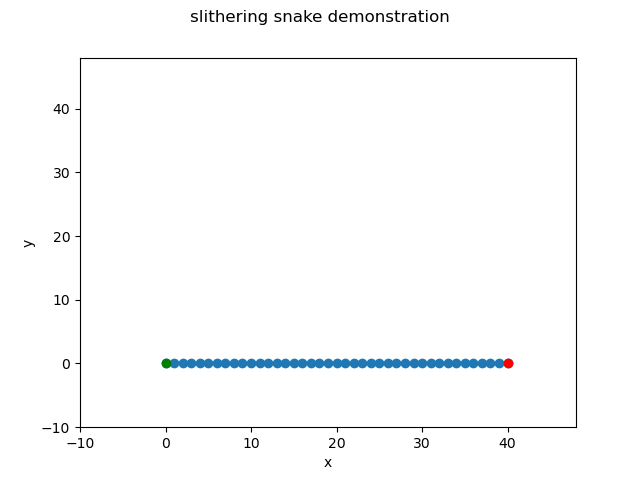

Widget Javascript not detected.  It may not be installed or enabled properly.


<function __main__.update_fig2(i)>

In [10]:
fig2,ax2 = plt.subplots()
fig2.suptitle('slithering snake demonstration')
x2,y2 = sawlist2[0].T
line2, = ax2.plot(x2[0],y2[0],'-o')
pt2a, = ax2.plot (x2[0],y2[0],'o',color='green')
pt2b, = ax2.plot (x2[-1],y2[-1],'o',color='red')
ax2.set_xlim(np.min(sawlist2)-1,np.max(sawlist2)+1)
ax2.set_ylim(np.min(sawlist2)-1,np.max(sawlist2)+1)
ax2.set_xlabel('x')
ax2.set_ylabel('y')
def update_fig2 (i):
    x2,y2 = sawlist2[i].T
    line2.set_xdata(x2)
    line2.set_ydata(y2)
    pt2a.set_xdata(x2[0])
    pt2a.set_ydata(y2[0])
    pt2b.set_xdata(x2[-1])
    pt2b.set_ydata(y2[-1])
    fig2.canvas.draw_idle()
widgets.interact(update_fig2,i=widgets.IntSlider(value=0,min=0,max=M2))

You should be able to see by experimenting with longish chains, that the slithering snake algorithm takes its time to produce something that looks different enough from the rather singular initial straight line. This is a problem if we want to do statistics: while the straight line is a valid configuration of a SAW, it becomes for large $N$ increasingly unlikely compared to many other configurations. But if we always start from it and perform too few iteration steps, we are assigning way too much weight to such rare configurations. In other words, we explore some small fraction of the configuration space (phase space) next to that "atypical" straight line, whereas meaningful statistical averages should at least sample a large enough "typical" part of that space. Here, "typical" and "atypical" alludes to the averages that we want to perform, in the sense that the mean of a quantity taken over the configurations that we visit should approximately as closely as possible the average taken over the whole ensemble. Again, this is a typical issue known to essentially every Monte Carlo computer simulation.

To remedy this situation, when calculation the mean-squared end-to-end distance as an average over the end-to-end distances measured for the (always few) configurations we generate, we omit some number of configurations corresponding to the first $M_{\text{init}}$ algorithmic steps. This allows the algorithm to hopefully "settle" into some more "typical" configurations around which we then explore.

It is in general work to be done: to prove that a given Monte Carlo algorithm actually has the property to provide, after some intial settling time, faithful samples of the vast configuration space of a given system. A prerequisite seems to be that it will eventually reach every allowed configuration of the system, if we let it run long enough. Algorithms with this property are called "ergodic", and all non-ergodic algorithms should be subject to some serious questioning. They might still be good for some purposes, but one has to be extra careful.

As it turns out, the slithering snake algorithm is not ergodic. It is actually easy to come up with configurations that the algorithm will never reach with our starting configuration. (Hint: these are called "double cul-de-sac" configurations.) Although the paper is not concerned primarily with the slithering snake algorithm, a very nice introduction to the sort of questions one needs to consider when constructing SAW and algorithms for SAW was published by Madras and Sokal [J. Stat. Phys. **47**, 573 (1987)].

## The "pivot rotation" algorithm

Leaving the question of ergodicity aside, one annoying aspect of the slithering snake algorithm was that it took so long to change our initial straight line into something looking more random. If the length $N$ is very large, adding bits at the end will of course take $\mathcal O(N)$ operations to change the straight line noticeably. To avoid this, we turn to an algorithm that even in a single operation step changes the conformation of any given walk much more radically.

The "pivot" algorithm again is a typical Monte Carlo scheme, assuming as input one valid SAW of given length $N$, returning a new one. Each step consists of selecting at random a "pivot point" on the given walk (think of it as a "hinge"), splitting the SAW into a head and a tail around that pivot, and rotating the tail part of the walk randomly around tht point. The rotation of course needs to be chosen compatible with the given lattice (so in 2D, rotations around multiples of 90 degrees are considered). If the procedure results in another valid SAW (i.e., if the rotated tail of the original walk does not overlap with the original head), the new configuration is accepted, else the old configuration is returned unchanged.

In [11]:
def pivotStep (path, rotations):
    # select a pivot to rotate around; excluding the trivial cases which are the ends of the given SAW
    pivot = np.random.choice (len(path)-2) + 1
    fixsec = path[:pivot]
    movsec = path[pivot:]
    rot = rotations[np.random.choice(len(rotations))] # randomly choose rotation
    newsec = np.array(list(map(lambda r: movsec[0]+rot.dot(r-movsec[0]), movsec)))
    allowed = True
    for tp in newsec:
        for p in fixsec:
            if np.array_equal(tp,p):
                allowed = False
    if allowed:
        return (np.append(fixsec,newsec,axis=0))
    else:
        return (np.copy(path))
def pivotSAW (n,d,m):
    rotations = squareGridRotations(d)
    saw = straightLine(d,n)
    sawlist = [saw]
    i = 0
    while i < m:
        sawlist = np.append(sawlist,[pivotStep(sawlist[-1],rotations)],axis=0)
        i += 1
    return (sawlist)
# again, a variant to only calculate the MSD
def pivotMSD (n,d,m,minit):
    rotations = squareGridRotations(d)
    saw = straightLine(d,n)
    msd = 0
    msdcnt = 0
    i = 0
    while i < m:
        saw = pivotStep(saw,rotations)
        if i >= minit:
            dr = saw[-1] - saw[0]
            msd += dr.dot(dr)
            msdcnt += 1
        i += 1
    return (msd/msdcnt)

For this to work, we need a set of allowed rotations, i.e., symmetry transforms of the given lattice.

In [20]:
def squareGridRotations (d):
    rotations = []
    for perm in itertools.combinations(range(d),2):
        id=np.identity(d)
        id[perm[0],perm[0]]=0
        id[perm[1],perm[1]]=0
        id[perm[0],perm[1]]=1
        id[perm[1],perm[0]]=-1
        rotations.append(np.copy(id))
        id[perm[0],perm[1]]=-1
        id[perm[1],perm[0]]=1
        rotations.append(np.copy(id))
        id=np.identity(d)
        id[perm[0],perm[0]]=-1
        id[perm[1],perm[1]]=-1
        rotations.append(id)
    return (rotations)
    return ([np.array([[0,-1],[1,0]]),np.array([[0,1],[-1,0]]),np.array([[-1,0],[0,-1]])])

Let us visualize the working of the algorithm in 2D:

In [13]:
N3 = 40
M3 = 1000
sawlist3 = pivotSAW (N3,2,M3)

<IPython.core.display.Javascript object>


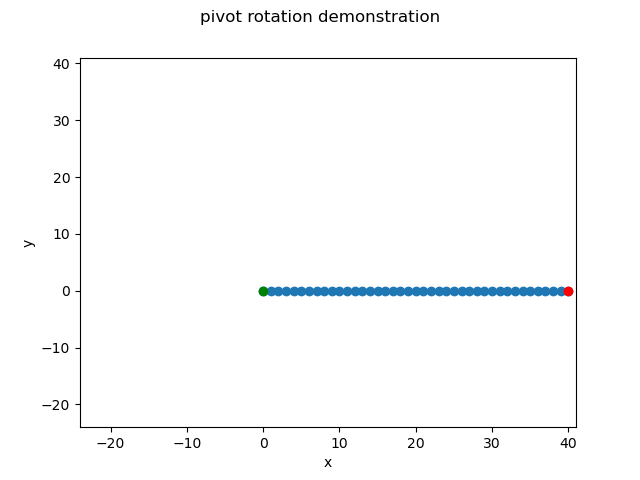

Widget Javascript not detected.  It may not be installed or enabled properly.


<function __main__.update_fig3(i)>

In [14]:
fig3,ax3 = plt.subplots()
fig3.suptitle('pivot rotation demonstration')
x3,y3 = sawlist3[0].T
bg3, = ax3.plot(x3[0],y3[0],'-')
line3, = ax3.plot(x3[0],y3[0],'-o',color=plt.rcParams['axes.prop_cycle'].by_key()['color'][0])
pt3a, = ax3.plot (x3[0],y3[0],'o',color='green')
pt3b, = ax3.plot (x3[-1],y3[-1],'o',color='red')
ax3.set_xlim(np.min(sawlist3)-1,np.max(sawlist3)+1)
ax3.set_ylim(np.min(sawlist3)-1,np.max(sawlist3)+1)
ax3.set_xlabel('x')
ax3.set_ylabel('y')
def update_fig3 (i):
    x3,y3 = sawlist3[i].T
    if i>0: i1=i-1
    else: i1=0
    x3o,y3o = sawlist3[i1].T
    bg3.set_xdata(x3o)
    bg3.set_ydata(y3o)
    line3.set_xdata(x3)
    line3.set_ydata(y3)
    pt3a.set_xdata(x3[0])
    pt3a.set_ydata(y3[0])
    pt3b.set_xdata(x3[-1])
    pt3b.set_ydata(y3[-1])
    fig3.canvas.draw_idle()
widgets.interact(update_fig3,i=widgets.IntSlider(value=0,min=0,max=M3))

## Scaling Laws

We now turn to the question how to determine the exponent $\nu$ for the scaling of the mean-squared end-to-end distance as a function of the number of steps $N$.

It should be noted that the above implementations of the algorithms are only intended for playing around a little. To do serious numerics with enough statistics and large chain lengths, the performance will not be sufficient. A main rason (apart from possible slowness of the language and its implementation here) is that our checks for overlaps are inefficient: they scale at least as $\mathcal O(N)$ for the slithering snake algorithm, but possibly $\mathcal O(N^2)$ for the pivot algorithm (worst case): if the pivot is somewhere in the middle, we perform $N/2$ checks for overlaps with $N/2$ fixed sites.

First it is instructive to check how the mean-squared end-to-end distance (from now on abbreviated as MSD) changes for fixed $N$ with the number of algorithm steps. This should give us an indication of how many steps we are likely to need before we can start averaging configurations. Note that for our choice of initial straight line, the MSD will always start at $N^2$, and should drop to $N^{2\nu}$ eventually (according to expectation). (In the following plot we add this expectation using the value $\nu=3/4$ for 2D SAW.)

In [15]:
N_msdtst1 = 50 # length of walks
M_msdtst1 = 150 # number of algorithm steps
Navg_msdtst1 = 10 # number of averages to perform
snake_msdtst1 = np.zeros(M_msdtst1+1)
pivot_msdtst1 = np.zeros(M_msdtst1+1)
for n in range(Navg_msdtst1):
    sawlist_snake_msdtst1 = slitheringSnakeSAW (N_msdtst1,2,M_msdtst1)
    sawlist_pivot_msdtst1 = pivotSAW (N_msdtst1,2,M_msdtst1)
    for i,saw in enumerate(sawlist_snake_msdtst1):
        dr = saw[-1] - saw[0]
        snake_msdtst1[i] += dr.dot(dr)
    for i,saw in enumerate(sawlist_pivot_msdtst1):
        dr = saw[-1] - saw[0]
        pivot_msdtst1[i] += dr.dot(dr)

<IPython.core.display.Javascript object>


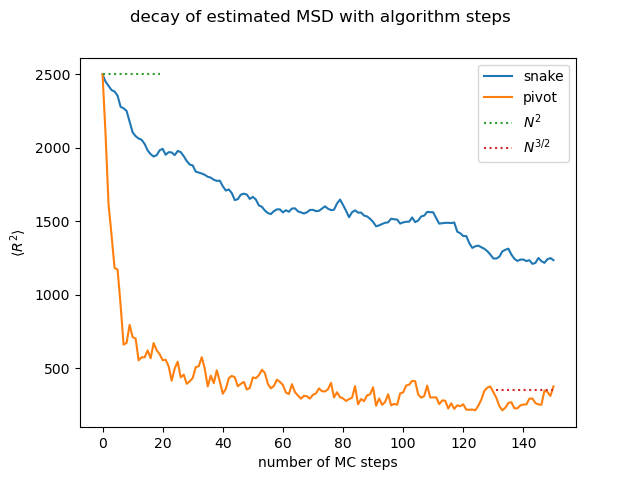

In [16]:
plt.figure()
plt.suptitle('decay of estimated MSD with algorithm steps')
plt.plot (np.arange(M_msdtst1+1),snake_msdtst1/Navg_msdtst1,label='snake')
plt.plot (np.arange(M_msdtst1+1),pivot_msdtst1/Navg_msdtst1,label='pivot')
plt.plot (np.arange(0,20),np.ones(20)*N_msdtst1*N_msdtst1,ls='dotted',label='$N^2$')
plt.plot (np.arange(M_msdtst1-19,M_msdtst1+1),np.ones(20)*np.power(N_msdtst1,1.5),ls='dotted',label='$N^{3/2}$')
plt.legend ()
plt.xlabel('number of MC steps')
plt.ylabel(r'$\langle R^2\rangle$')
plt.show ()

This is a very interesting result: the slithering snake algorithm is much faster to execute per step (because it just adds one segment as opposed to performing a costly rotation and multiple overlap checking), but it is per step much more inefficient in sampling. So, a much larger number of slithering-snake steps will be needed to achieve similarly good estimates of statistical averages as pivot steps.

It is not at all obvious from the outset (or intuitive) to decide which Monte Carlo algorithm will work well or won't. It turns out that the pivot algorithm is still believed to be among the best performers for SAW generation, as discussed by Madras and Sokal [J. Stat. Phys. **50**, 109 (1988)]. In that paper there is also a very interesting footnote: Alan Sokal, of later fame also through the Sokal spoof that consisted in publishing a nonsense paper in a respected social sciences journal to highglight some flaws of how scientific discussion was shaped, knew of an earlier implementation of the pivot algorithm by an author called Lal, but rejected it as outright inefficient due to a low acceptance rate of moves. When he started looking into the algorithm in earnest, he quickly changed his mind. As he writes: "A.D.S. wants to take this opportunity to atone publicly for his sins, and in particular to apologize to [another colleague] for having criticized his work unjustly."

One big effort undertaken by Madras and Sokal was to make the pivot algorithm fast by allowing for fast checks for overlaps. This works by adding all steps of the walk into a hash table, which has $\mathcal O(\log N)$ performance for finding whether a given site is already occupied. It is very interesting to read about the details of the implementation in the paper. It turns out that even more efficient methods of representing SAW in the computer can be devised, essentially storing them as binary trees that store sub-segments of the walk together with their bounding boxes, so that overlap detection becomes even more efficient. An improved implementation of the pivot algorithm was thus given as recently as 2010 by Clisby [Phys. Rev. Lett. **104**, 055702 (2010)], which made it possible to simulate SAW of length $N=33\times 10^6$ in 3D.

In [17]:
N_msd = np.arange(20,60,10)
snake_msd1 = np.array(list(map(lambda N:slitheringSnakeMSD(N,2,100*N,20*N),N_msd)))
pivot_msd1 = np.array(list(map(lambda N:pivotMSD(N,2,100*N,20*N),N_msd)))

<IPython.core.display.Javascript object>


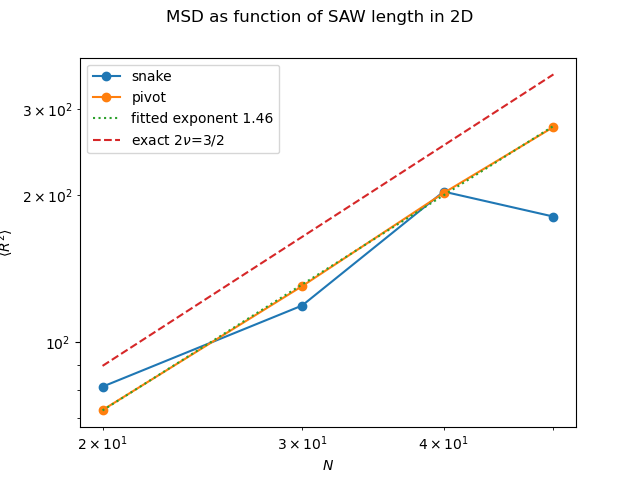

In [18]:
def linear_law (x,x0,nu):
    return x0+x*nu
popt,pcov = scipy.optimize.curve_fit (linear_law, np.log10(N_msd), np.log10(pivot_msd1))
plt.figure()
plt.suptitle('MSD as function of SAW length in 2D')
plt.loglog(N_msd,snake_msd1,'-o',label='snake')
plt.loglog(N_msd,pivot_msd1,'-o',label='pivot')
plt.loglog(N_msd,np.power(10.,popt[0])*np.power(N_msd,popt[1]),ls='dotted',label='fitted exponent {:.2f}'.format(popt[1]))
plt.loglog(N_msd,np.power(N_msd,1.5),ls='dashed',label=r'exact 2$\nu$=3/2')
plt.legend()
plt.xlabel(r'$N$')
plt.ylabel(r'$\langle R^2\rangle$')
plt.show()

Try to experiment... In the above, we have taken for length $N$ always $100N$ MC steps, discarding $20\%$ of the data before evaluating the MSD. (For the slithering snake, this appears to be still insufficient.)

To give an indication, here are some (insufficiently long and elaborate) runs in 3D and 4D using the pivot algorithm. (Aside note: for pivots, we use only the symmetry rotations around the lattice axes. The cubic lattice has a larger symmetry group because it also includes rotations around diagonals. For example in 3D, the cubic symmetry group has 48 elements, whereas we only use nine rotations. What matters is that we have a subgroup such that to each randomly picked group element we find the inverse with equal probability. This is the case, because the nine rotations come in groups of three, two of them inverse to each other and one self-inverse. These are the rotations around plus/minus 90 degrees and the rotation around 180 degrees around a fixed Cartesian axis.)

In [52]:
# WARNING: be patient, in particular when running this on mybinder.org or so

In [49]:
pivot_msd3 = np.array(list(map(lambda N:pivotMSD(N,3,200*N,40*N),N_msd)))

In [50]:
pivot_msd4 = np.array(list(map(lambda N:pivotMSD(N,4,200*N,40*N),N_msd)))

<IPython.core.display.Javascript object>


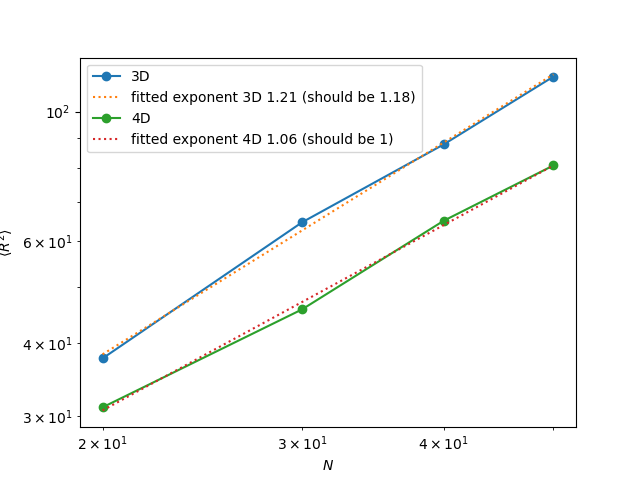

In [51]:
plt.figure()
plt.loglog(N_msd,pivot_msd3,'-o',label='3D')
popt,pcov = scipy.optimize.curve_fit (linear_law, np.log10(N_msd), np.log10(pivot_msd3))
plt.loglog(N_msd,np.power(10.,popt[0])*np.power(N_msd,popt[1]),ls='dotted',label='fitted exponent 3D {:.2f} (should be 1.18)'.format(popt[1]))
plt.loglog(N_msd,pivot_msd4,'-o',label='4D')
popt,pcov = scipy.optimize.curve_fit (linear_law, np.log10(N_msd), np.log10(pivot_msd4))
plt.loglog(N_msd,np.power(10.,popt[0])*np.power(N_msd,popt[1]),ls='dotted',label='fitted exponent 4D {:.2f} (should be 1)'.format(popt[1]))
plt.legend()
plt.xlabel(r'$N$')
plt.ylabel(r'$\langle R^2\rangle$')
plt.show()